## Problem statement

[Happy Data Year](https://boosters.pro/champ_21) was data analysis championship from Rosbank held from November 22 to January 10.

Participants should have predicted the geolocation-based popularity index for placing an ATM.

The training sample contains adresses of six thousand ATMs of Rosbank and its partners, as well as the target variable - the ATM popularity index. In the test sample, there are another two and a half thousand ATMs, equally divided into public and private parts.

The main feature of this contest was that participants have to collect geodata by their own. Hence the success depended not so much from models as from feature engineering.

## EDA

Lets look at the data first

In [63]:
import pickle
import math
from math import sin, cos, sqrt, atan2, radians
import time
import collections 

import osmread
from tqdm import tqdm_notebook
import wget
from collections import Counter
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import xgboost

from sklearn.decomposition import PCA
from sklearn import preprocessing as pr

from scipy import stats

import lightgbm as lgb

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

SEED = 12

In [26]:
train = pd.read_csv('../../../static/datasets/rosbank/train.csv', index_col=0)
test = pd.read_csv('../../../static/datasets/rosbank/test.csv', index_col=0)
train['isTrain'] = True
test['isTrain'] = False

full = train.append(test, sort=False)

In [27]:
full.shape

(8765, 8)

As you can see there are not so many features in the dataset:
* `id` is an unique indentifier of the ATM;
* `atm_group` is the id of the bank ATM belongs to.
* `address` is the only genuine featue which can tell us something about the location of the ATM;
* `address_rus` is the geocoded `address`, which was generated by organisers using Google Maps and Yandex Maps API.
* `lat` and `long` — latitude and longitude, genereted in the same way as the previous feature.
* `target` — popularity index.

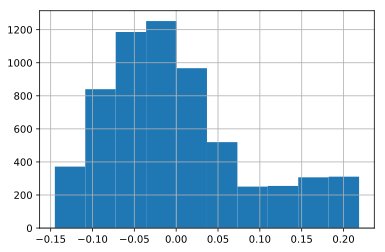

In [28]:
full.target.hist();

Distribution of `target` is quite normal, may it needs one simple transformation.

Lets look at the spatial distribution of ATMs using Folium library.

In [13]:
import folium
import branca

fmap = folium.Map(location=[55.805827, 70.515146], max_zoom=7)
colorscale = branca.colormap.linear.RdBu_04.scale(full.target.min(), full.target.max())
for index, row in full[["lat", "long", "isTrain", "target"]].dropna(subset=["lat", "long"]).sample(frac=1).iterrows():
    if row.isTrain:
        folium.CircleMarker(location=[row["lat"], row["long"]],
                            radius=10,
                            opacity=1,
                            weight=3,
                            color=colorscale(row.target),
                            tooltip=f"Index:{index},\nTarget: {row.target}").add_to(fmap)
    else:
        folium.RegularPolygonMarker(location=[row["lat"], row["long"]],
                            radius=10,
                            fill_opacity=0,
                            opacity=0.7,
                            weight=3,
                            color="#999999",
                            number_of_sides=3,
                            tooltip=index).add_to(fmap)
fmap.save('../../../static/pages/rosbank.html')

The map shows us the coordinates of ATMs. Points from the test set have the shape of a circle and from the test set have a shaoe of triangle. Color of ATMs from the train set demonstrates its popularity index — blue circles are more popular than red.

<div class="embed-responsive embed-responsive-1by1">
  <iframe class="embed-responsive-item" height="auto" src="/pages/rosbank.html" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen=""></iframe>
</div>

The distribution of the points is quite natural. We don't see any congestion of the points from the test or train set on the map.

## Baseline

Load all the data with the `create_full_df` function. Then extract the name of the city from the addresses and save it to the `city` column. Mark cities with less than 20 ATMs eith the name `RARE`, and then apply *label encoding*.

In [73]:
def create_full_df(city_label_enk=True):
    train = pd.read_csv('../../../static/datasets/rosbank/train.csv', index_col=0)
    test = pd.read_csv('../../../static/datasets/rosbank/test.csv', index_col=0)

    train['isTrain'] = True
    test['isTrain'] = False

    full = train.append(test, sort=False)

    full.id = full.id.astype("int")
    full.atm_group = full.atm_group.astype("category")

    counts = full.groupby('address_rus')['id'].count().reset_index().rename(columns={'id':'count'})
    full = pd.merge(full, counts, how='left', on='address_rus')
    
    full['city'] = full[~full.address_rus.isnull()].address_rus.apply(lambda x: x.split(',')[2]) 
    rare_cities = full.city.value_counts()[(full.city.value_counts() < 20) ==True].index
    if city_label_enk:
        full.city = full.city.apply(lambda x: 'RARE' if x in rare_cities else x)
        full.city = full.city.rank().astype("category")
    
    print("full_df created", time.ctime())
    return full

Implement [Haversine Formula](https://en.wikipedia.org/wiki/Haversine_formula) to calculate the `distance` between geographical points.

In [30]:
def distance(x,y):
    """    
    Params
    ----------
    x : tuple, lat, long of the first point
    y : tuple, lat, long of the second point
    6373.0 : radius of the Earth
    
    Result
    ----------
    result : distanse between two points
    """
    lat_a, long_a, lat_b, long_b = map(radians, [*x,*y])    
    dlon = long_b - long_a
    dlat = lat_b - lat_a
    a = sin(dlat/2)**2 + cos(lat_a) * cos(lat_b) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return 6373.0 * c

Then we define the function `add_kneighbors_atm`to calculate the distance between the nearest ATMs. The function takes a dataframe with the fields `lat`,` long` and adds to it the distance between each point and `n_neighbors` of other points closest to it, their indices, as well as the average distance to these points.

In [31]:
def add_kneighbors_atm(df, n_neighbors=7):
    df = df.copy()

    knc = NearestNeighbors(metric=distance)

    dots = df[['lat','long']].dropna()

    knc.fit(X=dots)

    distances, indexes = knc.kneighbors(X=dots, n_neighbors=n_neighbors)

    for i in range(1,6):
        dots['distance_%s'%i] = distances[:,i]
        dots['indexes_%s'%i] = indexes[:,i]
        dots['kurtosis_%s'%i] = stats.kurtosis(distances[:,i])
        dots['skew_%s'%i] = stats.skew(distances[:,i])
    dots['mean'] = dots.iloc[:,dots.columns.str.contains('distance')].mean(axis=1)

    df = pd.concat([df, dots.drop(columns=['lat', 'long'])], axis=1)
    print("neighbors added", time.ctime())
    return df

Define loss finction RMSE at last.

In [32]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [35]:
full = create_full_df()
full = add_kneighbors_atm(full)

full_df created Fri Jan 18 13:44:57 2019
neighbors added Fri Jan 18 13:45:25 2019


And get very preliminary results with LightGBM:

In [74]:
def simple_classifier(df):
    full = df.copy()
    full.isTrain = full.isTrain.fillna(False)
    col_drop = ['id', 'address', 'address_rus', 'target', 'isTrain'] + \
        [f'{n}_{i}' for i in range(1, 6) for n in ['indexes', 'kurtosis', 'skew']]
    
    X_ = full[full.isTrain].drop(columns=col_drop, errors='ignore')
    Y_ = full.loc[full.isTrain, 'target']

    X_train, X_valid, Y_train, Y_valid = train_test_split(
        X_, Y_, test_size=0.2, random_state=SEED
    )
    gbm = lgb.LGBMRegressor(objective = 'regression',  
                                max_depth = 3,
                                colsample_bytre = 0.8,
                                subsample = 0.8, 
                                learning_rate = 0.1,
                                n_estimators = 300,
                                random_state=SEED
                           )
    
    gbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)],
            eval_metric='rmse', early_stopping_rounds=5, verbose=False);
    
    print("RMSE: {rmse:.4}\nR^2: {r2:.3}".format(
        rmse=rmse(Y_valid, gbm.predict(X_valid)),
        r2=r2_score(Y_valid, gbm.predict(X_valid))
    ))
    return gbm

gbm = simple_classifier(full)

RMSE: 0.04492
R^2: 0.726


Initially, we see a pretty good quality of predictions.

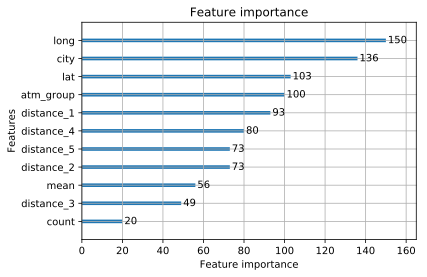

In [75]:
lgb.plot_importance(gbm);

The most important feature is the longitude, the second important featue is the city. Apparently, this is a consequence of the uneven development of the regions. In some cities, mainly in the west, ATMs are often used, in the east - less.

# Adding features from Open Street Maps

One of the main parts of data analysis is the generation of features. If we have the coordinates of a point, we can recognize its environment, which almost always affects the performance of our model. Information about the environment can be gathered from the Open Street Maps. Russian maps in <abbr title="point of interest">POIs</abbr> can be downloaded at https://download.geofabrik.de/russia-latest.osm.pbf.

Lets investigate how far away from ATMs placed important objects that, at our opinion, will affect their popularity - metro stations, shops, etc. Something similar was done in the article “[How to predict the number of emergency calls in different parts of the city?] (https://habr.com/company/ru_mts/blog/353334/) ".

So, first we need to parse the source file with all the objects that are marked on the map of Russia. In the structure of the OSM file there are [three kinds of objects] (https://wiki.openstreetmap.org/wiki/Elements) - `Node`,` Way` and `Relation`. We are most likely to be interested in the objects of the first type - these are any points on the map from benches to cities. It is more difficult to count the distance from ATMs to the ways, and it’s not at all clear what to do with relationships.

Also, any type of object can have a property `tags` - this is a dictionary with very dofferent attributes — type, name, working hours, etc.

Let's select objects of type `node`, which are described by at least one attribute. Since the data file took several gigabytes, the filtering process took several hours.

In [38]:
def extract_osm_tags():
    # wget.download("https://download.geofabrik.de/russia-latest.osm.pbf")
    
    osm_file = osmread.parse_file('russia-latest.osm.pbf')
    
    tagged_nodes = [
        entry
        for entry in tqdm_notebook(osm_file)
        if isinstance(entry, osmread.Node)
        if len(entry.tags) > 0
    ]
    with open('tagged_nodes.pickle', 'wb') as fout:
        pickle.dump(tagged_nodes, fout, protocol=pickle.HIGHEST_PROTOCOL)

It turned out to find more than 4.6 million points that satisfy our conditions. We pickled them in a [file](/datasets/rosbank/tagged_nodes.pickle.zip) for the fearther use.

In [40]:
with open('/datasets/rosbank/tagged_nodes.pickle.zip', 'rb') as fin:
    tagged_nodes = pickle.load(fin)

In [41]:
all_tags = [k for node in tagged_nodes for k in node.tags.keys()]
len(all_tags)

9528332

In [42]:
tags_counter = Counter(all_tags)
len(tags_counter)

4313

We see enormous amount of unique tags — 9528332, and 4313 if unique tags. What is the distridution of the tags?

In [44]:
tags_counter.most_common(30)

[('power', 1646586),
 ('name', 849474),
 ('highway', 359997),
 ('amenity', 352595),
 ('source', 329248),
 ('entrance', 279908),
 ('created_by', 246999),
 ('shop', 246985),
 ('natural', 235112),
 ('barrier', 225253),
 ('ref', 209322),
 ('addr:housenumber', 193533),
 ('addr:street', 192234),
 ('place', 191271),
 ('addr:country', 132953),
 ('opening_hours', 124167),
 ('operator', 113489),
 ('railway', 104798),
 ('name:ru', 104460),
 ('crossing', 104392),
 ('addr:flats', 95497),
 ('addr:region', 95194),
 ('public_transport', 93675),
 ('addr:district', 88876),
 ('building', 87351),
 ('wikidata', 84128),
 ('wikipedia', 83524),
 ('addr:postcode', 81975),
 ('addr:city', 73604),
 ('name:en', 72904)]

Very uneven, as wee see. The difference detween the most prevalent tag and top-20 tag is large.

So in 4601457 objects we found 4313 unique tags, which is too much, especially considering their uneven distribution - even the third most popular tag is found in less than 10% of observations (most of all, by the way, electrical infrastructure ([power] (https://wiki.openstreetmap.org/wiki/Key:power)) - supports of electric transmission lines and everything related).

The dimension can be reduced by removing not very useful tags. For example, in many of the name of the object is written in different languages and in different styles: `name`,` name: en`, `official_name`, etc. We could to get rid of them, but lets make features that will show the amount of different names. Probably, these features will talk about the popularity of the object.

The same for tags starting with `wikipedia` is [links to Wikipedia articles in different languages] (https://wiki.openstreetmap.org/wiki/Key:wikipedia).

I did not decide do I need to remove the `color` tag, so leave it.

In [45]:
tagged_nodes_list = []
for node in tqdm_notebook(tagged_nodes):
    
    d = {k: v for k, v in  node.tags.items()
         if not
         (k.startswith("name:")
          or k.startswith("old_name")
          or k.startswith("alt_name")
          or k.startswith("wikipedia")
          #or k.startswith("color:") 
          or k.startswith("official_name:")
         )
        }
    num_names = len([k for k in node.tags.keys() if k.startswith("name")])
    num_official_names = len([k for k in node.tags.keys() if k.startswith("official_name")])
    num_alt_names = len([k for k in node.tags.keys() if k.startswith("alt_name")])
    num_old_names = len([k for k in node.tags.keys() if k.startswith("old_name")])
    num_all_names = num_names + num_official_names + num_alt_names + num_old_names
    num_wiki = len([k for k in node.tags.keys() if k.startswith("wikipedia")])
    
    d.update({
        "lat": node.lat,
        "lon": node.lon,
        "id": node.id,
        "timestamp": node.timestamp,
        "num_names": num_names,
        "num_official_names": num_official_names,
        "num_alt_names": num_alt_names,
        "num_old_names": num_old_names,
        "num_all_names": num_all_names,
        "num_wiki": num_wiki
    })
    tagged_nodes_list.append(d)

The number of tags was redused from 4313 to 3755 (13% less):

In [76]:
c = Counter([tag for node in tagged_nodes_list for tag in node])
len(c)

3755

And the tags that are found in more than 500 objects are only 337 (their total number, let me remind you, is more than 4.6 million):

In [47]:
frq_titles = [title for title, count in c.most_common() if count > 500]
len(frq_titles)

337

Now we can select all the tags to calculate 1) the distance between ATMs and N, where $N\in[1, 3, 5, 10]$nearby points and 2) nummber of different points in a certain radius.

In [ ]:
df_features = collections.OrderedDict([])

# Set of points we are interested in
POINT_FEATURE_FILTERS = [
    ('tagged', lambda 
     node: len(node.tags) > 0),
    ('railway=station', lambda node: node.tags.get('railway') == 'station'),
] + [(i, lambda node: i in node.tags) for i in frq_titles if i is not 'id']


X_zone_centers = full[['lat', 'long']].dropna().values

for prefix, point_filter in tqdm_notebook(POINT_FEATURE_FILTERS, desc='Фильтр'):

    coords = np.array([
        [node.lat, node.lon]
        for node in tagged_nodes
        if point_filter(node)
    ])


    neighbors = NearestNeighbors().fit(coords)
    
    # feature "number of points in radius R"
    for radius in [0.001, 0.003, 0.005, 0.007, 0.01]:
        dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
        df_features['{}_points_in_{}'.format(prefix, radius)] = \
            np.array([len(x) for x in inds])

    # feature "distance to the nearest K points"
    for n_neighbors in [1, 3, 5, 10]:
        dists, inds = neighbors.kneighbors(X=X_zone_centers, n_neighbors=n_neighbors)
        df_features['{}_mean_dist_k_{}'.format(prefix, n_neighbors)] = \
            dists.mean(axis=1)
        df_features['{}_max_dist_k_{}'.format(prefix, n_neighbors)] = \
            dists.max(axis=1)
        df_features['{}_std_dist_k_{}'.format(prefix, n_neighbors)] = \
            dists.std(axis=1)

    # featue "distance to the any nearest point"
    df_features['{}_min'.format(prefix)] = dists.min(axis=1)

# save new data
df_features = pd.DataFrame(df_features, index=full[['lat', 'long']].dropna().index)
df_features.to_csv('/datasets/rosbank/features_500.csv.zip', compression='zip')

In [50]:
df_features = pd.read_csv('../../../static/datasets/rosbank/features_500.csv.zip', compression='zip', index_col=0)
df_features.head()

,tagged_points_in_0.001,tagged_points_in_0.003,tagged_points_in_0.005,tagged_points_in_0.007,tagged_points_in_0.01,tagged_mean_dist_k_1,tagged_max_dist_k_1,tagged_std_dist_k_1,tagged_mean_dist_k_3,tagged_max_dist_k_3,...,ruins_mean_dist_k_3,ruins_max_dist_k_3,ruins_std_dist_k_3,ruins_mean_dist_k_5,ruins_max_dist_k_5,ruins_std_dist_k_5,ruins_mean_dist_k_10,ruins_max_dist_k_10,ruins_std_dist_k_10,ruins_min
id,,,,,,,,,,,,,,,,,,,,,
8526,0,1,9,54,127,0.002476,0.002476,0.0,0.003067,0.003431,...,5.291163,5.291224,0.000050,5.291307,5.291765,0.000237,5.291705,5.292427,0.000463,5.291101
8532,4,16,36,64,127,0.000393,0.000393,0.0,0.000615,0.000731,...,5.275803,5.275864,0.000050,5.275947,5.276405,0.000237,5.276346,5.277068,0.000463,5.275742
8533,11,133,272,447,843,0.000348,0.000348,0.0,0.000372,0.000395,...,5.294956,5.295017,0.000050,5.295101,5.295560,0.000237,5.295501,5.296225,0.000465,5.294894
8684,79,467,955,1409,2054,0.000052,0.000052,0.0,0.000183,0.000260,...,0.352660,0.495956,0.175553,0.446310,0.589103,0.177902,0.682405,1.099252,0.282489,0.105433
37,8,69,141,218,286,0.000168,0.000168,0.0,0.000339,0.000513,...,15.634626,18.100765,1.757582,18.533833,25.578784,4.167641,24.116806,31.336085,6.483454,14.132749


So, we generated a bunch of features showing the distance between ATMs, from ATMs to all possible points from among the top 500, and the number of these points in different radii. It turned out 6087 features, most of which, of course, are irrelevant. What is next? Of course ...

## Feature Selection

For further work, it is necessary to select the most important features, for example, 300 of them. Let us turn to the methods of feature extraction called **Wrapper method**s with the random forest model. I wrote about feature selection methods in the article [Feature engineering](/courses/data-science/feature_engineering/).

In [79]:
mega_full = pd.concat([full.set_index("id"), df_features], sort=False, axis=1)

In [82]:
col_drop = ['address', 'address_rus', 'target', 'isTrain']

In [ ]:
def select_features(df):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.feature_selection import RFE
    
    X = df.query('isTrain == True').drop(columns=col_drop)
    y = df.query('isTrain == True')['target']

    rfr = RandomForestRegressor(n_jobs=4, random_state=SEED, n_estimators=10, verbose=0)
    rfr_selector = RFE(rfr, n_features_to_select=10, step=10, verbose=0)
    rfr_selector = rfr_selector.fit(X, y)
    
    features_ranks = {i: X.columns[rfr_selector.ranking_ <= i] for i in set(rfr_selector.ranking_)}
    pickle.dump(features_ranks, open("../../../static/datasets/rosbank/features_ranks.pickle", "wb"))
    
    return features_ranks

https://nagornyy.me/datasets/rosbank/features_ranks.pickle.zip

In [58]:
best_features = pickle.load(open('../../../static/datasets/rosbank/features_ranks.pickle', 'rb'))

Here we see the names of the top-45 features.

In [59]:
for tier in list(best_features)[:10]:
    print(tier, len(best_features[tier]))
    
print(' 💥 '.join(best_features[5]))

1 10
2 15
3 25
4 35
5 45
6 55
7 65
8 75
9 85
10 95
atm_group 💥 lat 💥 long 💥 count 💥 distance_1 💥 distance_2 💥 distance_3 💥 distance_4 💥 distance_5 💥 mean 💥 tagged_points_in_0.003 💥 tagged_points_in_0.005 💥 tagged_points_in_0.007 💥 tagged_points_in_0.01 💥 tagged_mean_dist_k_1 💥 tagged_max_dist_k_1 💥 tagged_mean_dist_k_3 💥 tagged_max_dist_k_3 💥 tagged_std_dist_k_3 💥 tagged_std_dist_k_5 💥 tagged_max_dist_k_10 💥 tagged_std_dist_k_10 💥 railway=station_max_dist_k_1 💥 railway=station_mean_dist_k_3 💥 railway=station_max_dist_k_3 💥 railway=station_std_dist_k_3 💥 railway=station_mean_dist_k_5 💥 railway=station_max_dist_k_5 💥 railway=station_std_dist_k_5 💥 railway=station_mean_dist_k_10 💥 railway=station_max_dist_k_10 💥 railway=station_std_dist_k_10 💥 ref_max_dist_k_5 💥 addr:street_std_dist_k_5 💥 bicycle_max_dist_k_3 💥 contact:vk_mean_dist_k_5 💥 covered_min 💥 start_date_std_dist_k_10 💥 payment:mastercard_std_dist_k_3 💥 bic_mean_dist_k_10 💥 post_box:type_max_dist_k_10 💥 surveillance:zone_max_dist_

RMSE: 0.04453
R^2: 0.729


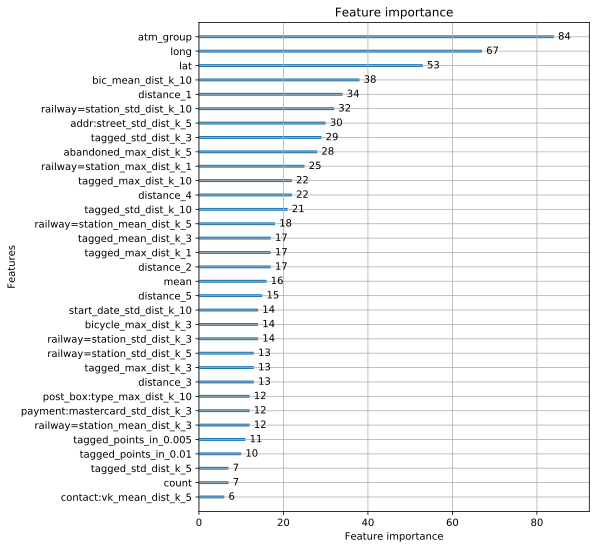

In [83]:
mega_full.atm_group = mega_full.atm_group.astype("category")#cat.add_categories(-1).fillna(-1)
mega_full.city = mega_full.city.astype("category")#cat.add_categories(-1).fillna(-1)

lgb.plot_importance(
    simple_classifier(mega_full[best_features[4].tolist() + ['target', 'isTrain']]),
    figsize=(7, 9)
);

## Самостоятельное задание

**Я собрал базу банкоматов с banki.ru, чтобы улучшить результаты классификатора. К сожалению, я не успел применить их в модели. Ваша задача — закончить построение классификатора используюя эти данные.** 

**Далее идёт часть ноутбука с кодом загрузки данных и ссылкой на скачивания готового файла.**

База банкоматов, которую выдали организаторы, очевидно неполная. Здравый смысл подсказывает, что в стране установлено намного больше ≈9000 банкоматов. Скорее, это число исчисляется стонями тысяч. Следовательно, один из путей повышения качества классификатора — расширение базы данных.

Также хорошо было бы увеличить количество информации о каждом банкомате. Если мы хотим выявить предикторы популярности, то, кажется, одинм из самых важных из них будет график работы. Однако это информации нет ни в исходных данных, ни в OSM.

Но где достать наиболее полную базу банкоматов России? Тут на помощь приходит сайт [banki.ru](https://www.banki.ru/banks), где, помимо всего прочего собрана огромная [база отделений банков и банкоматов](https://www.banki.ru/banks/map/moskva/). Кстати говоря, очень рекомендую это сайт — так куча полезных статей, информации о вкладах, кретитных тарифах и т.п.

Итак, нам необходимо собрать этот набора данных сайта. О веб-скраппинге и парсинге я подробно писал в [соответсвующей статье](/data-science/scrapping-parsing/).

Загрузка данных будет происходить в три этапа:
1. Загрузка списка городов.
2. Загрузка списка банкоматов из каждого города.
3. Загрузка расширенной информации о каждом банкомате. Тут нас больше всего будет интересовать время его работы.

## Загрузка списка городов
К счастью, города можно загрузить в формате JSON по [прямому URL](https://www.banki.ru/bitrix/components/banks/universal.select.region/ajax.php?bankid=0&baseUrl=%2Fbanks%2Fmap%2F&appendUrl=&type=city).

![](img/banki.ru_cities.png)

Всего в базе 9276 городов. Ожидаемо, больше всего банкоматов в Москве, затем идут Санкт-Петербург и Новосибирск.

In [44]:
import requests
import pandas as pd
import json
from tqdm import tqdm_notebook
import time
import pickle
import math

In [21]:
url_cities = ('https://www.banki.ru/bitrix/components/banks/universal.select.region/ajax.php' +
    '?bankid=0&baseUrl=%2Fbanks%2Fmap%2F&appendUrl=&type=city')
res_cities = requests.get(url_cities)

In [22]:
sorted(res_cities.json()['data'], key=lambda x: x['count'], reverse=True)[:3]

[{'id': 4,
  'region_name': 'Москва',
  'count': 9357,
  'url': '/banks/map/moskva/',
  'region_code': 'moskva',
  'region_id': 4,
  'region_name_full': 'Москва',
  'kladr_code': '7700000000000'},
 {'id': 211,
  'region_name': 'Санкт-Петербург',
  'count': 4689,
  'url': '/banks/map/sankt-peterburg/',
  'region_code': 'sankt-peterburg',
  'region_id': 211,
  'region_name_full': 'Санкт-Петербург',
  'kladr_code': '7800000000000'},
 {'id': 677,
  'region_name': 'Новосибирск',
  'count': 1841,
  'url': '/banks/map/novosibirsk/',
  'region_code': 'novosibirsk',
  'region_id': 677,
  'region_name_full': 'Новосибирск',
  'kladr_code': '5400000100000'}]

## Загрузка списка банкоматов из каждого города

Для загрузки банкоматов из города необходимо делать POST-запросы с определёнными заголовками на адрес https://www.banki.ru/api/. Заголовки можно скопировать из Chrome Developer Tools в формате cURL. Тут я хочу пожелать здоровья человеку, который сдел [сервис для перевода формата cURL в пригодный для использования Питоновским моделуем requests](https://curl.trillworks.com/).

NB: если запросы будут выполняться слишком часто, сайт попросит вести каптчу, что нам совершенно не нужно. Чтобы избежать этого, добавим пазузу в 0.3 секунды между запросами.

In [14]:
headers = {
    'cookie': 'PHPSESSID=93bfdc45fd9cc9a8a8a3d50c2447639e; BANKI_RU_USER_IDENTITY_UID=5549793729193099991; aff_sub3=main; uid=uQo9b1wiJOM7IVHaBCLlAg==; __utmc=241422353; _ga=GA1.2.199415927.1545741541; _ym_uid=1545741541860272573; _ym_d=1545741541; ga_client_id=199415927.1545741541; scs=%7B%22t%22%3A1%7D; flocktory-uuid=721c443d-8411-4607-8c77-9eaa3490ad79-2; sbjs_migrations=1418474375998%3D1; sbjs_first_add=fd%3D2018-12-25%2015%3A39%3A03%7C%7C%7Cep%3Dhttps%3A%2F%2Fwww.banki.ru%2F%7C%7C%7Crf%3Dhttps%3A%2F%2Fwww.google.com%2F; sbjs_first=typ%3Dorganic%7C%7C%7Csrc%3Dgoogle%7C%7C%7Cmdm%3Dorganic%7C%7C%7Ccmp%3D%28none%29%7C%7C%7Ccnt%3D%28none%29%7C%7C%7Ctrm%3D%28none%29; ins-mig-done=1; lp_vid=c522904b-b4ae-467f-5a09-f28119eb8f57; spUID=1545741543376ba14961ee0.919b1d92; __io_lv=1545741551218; __io_uid_test=8; __io=5e24aa2a9.d4efafdc0_1545741551223; _io_un=; _io_un=; _io_un=25; __utmv=241422353.|1=siteDesign=new=1; lp_abtests=[{"SessionId":"300285","WidgetId":4568,"TestId":37}]; views_counter=%7B%22news%22%3A%5B10802672%5D%7D; _gid=GA1.2.1726664245.1546467651; __utmz=241422353.1546467651.2.2.utmcsr=google|utmccn=(organic)|utmcmd=organic|utmctr=(not%20provided); _ym_isad=1; BANKI_RU_GUEST_ID=606957941; user-region-id=1; _fbp=fb.1.1546526535416.1197015680; decid_cache=1261000702; decid_png=1261000702; decid_etag=1261000702; DEC_ID=1261000702; BANKI_RU_DLDB=1265655189; __utma=241422353.199415927.1545741541.1546533080.1546536112.6; __utmt=1; _ic_c=6..google_organic; sbjs_current_add=fd%3D2019-01-03%2020%3A21%3A52%7C%7C%7Cep%3Dhttps%3A%2F%2Fwww.banki.ru%2Fbanks%2Fmap%2Fbarnaul%2F%23%2F%21b1%3Aall%21s3%3Abankomaty%21s4%3Alist%21m4%3A1%21p1%3A1%7C%7C%7Crf%3Dhttps%3A%2F%2Fwww.banki.ru%2Fbanks%2Fmap%2Fbarnaul%2F; sbjs_current=typ%3Dreferral%7C%7C%7Csrc%3Dbanki.ru%7C%7C%7Cmdm%3Dreferral%7C%7C%7Ccmp%3D%28none%29%7C%7C%7Ccnt%3D%2Fbanks%2Fmap%2Fbarnaul%2F%7C%7C%7Ctrm%3D%28none%29; sbjs_udata=vst%3D6%7C%7C%7Cuip%3D%28none%29%7C%7C%7Cuag%3DMozilla%2F5.0%20%28Macintosh%3B%20Intel%20Mac%20OS%20X%2010_14_2%29%20AppleWebKit%2F537.36%20%28KHTML%2C%20like%20Gecko%29%20Chrome%2F71.0.3578.98%20Safari%2F537.36; ins-gaSSId=a8a876f6-e72b-5ea9-6348-60de0df03b4b_1546536114; lp_session=247585; _ym_visorc_502212=b; NonRobot=15465365840c4f6fe5021cfba98ee584c8ed0c080b729+acfc037aae7e3cd2095d5a5c38fcbc1d; __utmb=241422353.5.10.1546536112; _gat=1; _gat_bankiru_test=1; sbjs_session=pgs%3D5%7C%7C%7Ccpg%3Dhttps%3A%2F%2Fwww.banki.ru%2Fbanks%2Fmap%2Fbarnaul%2F%3F%23%2F%21b1%3Aall%21s3%3Abankomaty%21s4%3Alist%21m1%3A12%21m2%3A53.356132%21m3%3A83.74962%21p1%3A1; tmr_detect=1%7C1546536586502; BANKI_RU_LAST_VISIT=03.01.2019+20%3A29%3A46; BANKI_RU_BANNERS=452_20055_1_04012019%2C452_10427_1_04012019%2C106_10808_1_04012019%2C106_797_15_04012019%2C106_809_11_04012019; insdrSV=32; lp_pageview=5; _gat_UA-38591118-1=1; bank_geo_link=#/!b1:all!s3:bankomaty!s4:list!m1:12!m2:53.356132!m3:83.74962!p1:1',
    'origin': 'https://www.banki.ru',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8,ru;q=0.7',
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36',
    'content-type': 'application/x-www-form-urlencoded; charset=UTF-8',
    'accept': 'application/json, text/javascript, */*; q=0.01',
    'referer': 'https://www.banki.ru/banks/map/barnaul/?',
    'authority': 'www.banki.ru',
    'x-requested-with': 'XMLHttpRequest',
    'save-data': 'on',
}


data = {
    "jsonrpc":"2.0",
    "method":"bankGeo/getObjectsByFilter",
    "params":{
        "with_empty_coordinates":True,
        "limit":10000,
        "type":["atm","self_office"],
        "region_id":[]
    },
    "id":"2"
}


In [16]:
atms_all = []

for city in tqdm_notebook(res_cities.json()['data']):
    data['params']['region_id'] = [city['region_id']]
    response_atms_city = requests.post('https://www.banki.ru/api/', headers=headers, data=json.dumps(data))
    time.sleep(0.3) # иначе просят ввести каптчу
    atms_city = response_atms_city.json()['result']['data'].copy()
    for atm in atms_city:
        atm.update({
            "region": city["region_name"]
        })
        atms_all.append(atm)

Неплохой услов! Мы собрали информацию о 86021 банкомате за полтора часа, что гораздо больше, чем дали нам организаторы.

In [25]:
atms_all_df = pd.DataFrame(atms_all)
atms_all_df.head()

,active,address,bank_id,icon_url,id,is_main,latitude,longitude,name,region,region_id,sort,type
0,True,"г. Москва, пер. Малый Сухаревский, д. 7",9259,/upload/iblock/a0d/9259.gif,6588499,True,55.770445,37.623941,Банкомат,Москва,4,5,atm
1,True,"г. Москва, просп. Кутузовский, д. 24",9259,/upload/iblock/a0d/9259.gif,6572679,True,55.744597,37.545693,Банкомат,Москва,4,5,atm
2,True,"г. Москва, ул. Малая Дмитровка, д. 10",9259,/upload/iblock/a0d/9259.gif,7122179,True,55.768714,37.606467,Банкомат,Москва,4,5,atm
3,True,"г. Москва, ул. Садовая-Черногрязская, д. 3 Б, ...",9259,/upload/iblock/a0d/9259.gif,8493289,True,55.767398,37.652819,Банкомат,Москва,4,5,atm
4,True,"г. Москва, ул. Бакунинская, д. 23/41",9259,/upload/iblock/a0d/9259.gif,6602441,True,55.775659,37.683584,Банкомат,Москва,4,5,atm


## Загрузка расширенной информации о каждом банкомате

Здесь почти всё так же, как и в предыдущем шаге, только посылаем немного другие данные — в `params` > `id_list` нужно поместить список `id` нужных нам банкоматов. Если список будет слишком большой, получится ошибка, поэтому разобьем ранее собранный список банкоматов на пакеты по 500 штук, а затем будем запрашивать информацию о каждом пакете по очереди.

In [87]:
headers = {
    'cookie': 'PHPSESSID=93bfdc45fd9cc9a8a8a3d50c2447639e; BANKI_RU_USER_IDENTITY_UID=5549793729193099991; aff_sub3=main; uid=uQo9b1wiJOM7IVHaBCLlAg==; __utmc=241422353; _ga=GA1.2.199415927.1545741541; _ym_uid=1545741541860272573; _ym_d=1545741541; ga_client_id=199415927.1545741541; scs=%7B%22t%22%3A1%7D; flocktory-uuid=721c443d-8411-4607-8c77-9eaa3490ad79-2; sbjs_migrations=1418474375998%3D1; sbjs_first_add=fd%3D2018-12-25%2015%3A39%3A03%7C%7C%7Cep%3Dhttps%3A%2F%2Fwww.banki.ru%2F%7C%7C%7Crf%3Dhttps%3A%2F%2Fwww.google.com%2F; sbjs_first=typ%3Dorganic%7C%7C%7Csrc%3Dgoogle%7C%7C%7Cmdm%3Dorganic%7C%7C%7Ccmp%3D%28none%29%7C%7C%7Ccnt%3D%28none%29%7C%7C%7Ctrm%3D%28none%29; ins-mig-done=1; lp_vid=c522904b-b4ae-467f-5a09-f28119eb8f57; spUID=1545741543376ba14961ee0.919b1d92; __io_lv=1545741551218; __io_uid_test=8; __io=5e24aa2a9.d4efafdc0_1545741551223; _io_un=; _io_un=; _io_un=25; __utmv=241422353.|1=siteDesign=new=1; lp_abtests=[{"SessionId":"300285","WidgetId":4568,"TestId":37}]; views_counter=%7B%22news%22%3A%5B10802672%5D%7D; _gid=GA1.2.1726664245.1546467651; __utmz=241422353.1546467651.2.2.utmcsr=google|utmccn=(organic)|utmcmd=organic|utmctr=(not%20provided); BANKI_RU_GUEST_ID=606957941; user-region-id=1; _fbp=fb.1.1546526535416.1197015680; decid_cache=1261000702; decid_png=1261000702; decid_etag=1261000702; DEC_ID=1261000702; BANKI_RU_DLDB=1265655189; sbjs_current=typ%3Dreferral%7C%7C%7Csrc%3Dbanki.ru%7C%7C%7Cmdm%3Dreferral%7C%7C%7Ccmp%3D%28none%29%7C%7C%7Ccnt%3D%2Fbanks%2Fmap%2Fbarnaul%2F%7C%7C%7Ctrm%3D%28none%29; NonRobot=15465365840c4f6fe5021cfba98ee584c8ed0c080b729+acfc037aae7e3cd2095d5a5c38fcbc1d; __utma=241422353.199415927.1545741541.1546536112.1546536737.7; _ic_c=7..google_organic; sbjs_current_add=fd%3D2019-01-03%2021%3A28%3A04%7C%7C%7Cep%3Dhttps%3A%2F%2Fwww.banki.ru%2Fbanks%2Fmap%2Fmoskva%2F%7C%7C%7Crf%3Dhttps%3A%2F%2Fwww.banki.ru%2Fbanks%2Fmap%2Fbarnaul%2F%3F; sbjs_udata=vst%3D7%7C%7C%7Cuip%3D%28none%29%7C%7C%7Cuag%3DMozilla%2F5.0%20%28Macintosh%3B%20Intel%20Mac%20OS%20X%2010_14_2%29%20AppleWebKit%2F537.36%20%28KHTML%2C%20like%20Gecko%29%20Chrome%2F71.0.3578.98%20Safari%2F537.36; _ym_isad=1; ins-gaSSId=1b8edf15-7c15-36e1-ee0e-84d01dea36eb_1546540085; lp_session=271976; __utmt=1; __utmb=241422353.5.9.1546540079434; _gat=1; tmr_detect=1%7C1546543574331; _gat_bankiru_test=1; _ym_visorc_502212=b; BANKI_RU_LAST_VISIT=03.01.2019+22%3A26%3A14; insdrSV=38; BANKI_RU_BANNERS=452_20055_1_04012019%2C452_10427_1_04012019%2C106_10808_1_04012019%2C106_797_17_04012019%2C106_809_15_04012019; sbjs_session=pgs%3D4%7C%7C%7Ccpg%3Dhttps%3A%2F%2Fwww.banki.ru%2Fbanks%2Fmap%2Fmoskva%2F%23%2F%21b1%3Aall%21s3%3Abankomaty%21s4%3Alist%21m1%3A10%21m2%3A55.755773%21m3%3A37.617761%21p1%3A1; lp_pageview=3; bank_geo_link=#/!b1:all!s3:bankomaty!s4:list!m1:10!m2:55.755773!m3:37.617761!p1:2',
    'origin': 'https://www.banki.ru',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8,ru;q=0.7',
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36',
    'content-type': 'application/x-www-form-urlencoded; charset=UTF-8',
    'accept': 'application/json, text/javascript, */*; q=0.01',
    'referer': 'https://www.banki.ru/banks/map/moskva/',
    'authority': 'www.banki.ru',
    'x-requested-with': 'XMLHttpRequest',
    'save-data': 'on',
}

data = {
    "jsonrpc":"2.0",
    "method":"bank/getBankObjectsData",
    "params":{
        "id_list": []
    },
    "id":"6"
}

#response = requests.post('https://www.banki.ru/api/', headers=headers, data=json.dumps(data))

In [ ]:
num_batches = math.ceil(len(atms_all)/500)

allAtms_fullInfo = []

for batch in tqdm_notebook(range(0, num_batches)):
    data['params']['id_list'] = [atm['id'] for atm in atms_all[batch * 500: (batch + 1) * 500]]
    response = requests.post('https://www.banki.ru/api/', headers=headers, data=json.dumps(data))
    time.sleep(.3)
    try:
        allAtms_fullInfo.extend(response.json()['result']['data'])
    except KeyError as err:
        print(err, response.json())

pickle.dump(allAtms_fullInfo, open('output/banki.ru_atms_fullInfo.pickle', 'wb'))
len(allAtms_fullInfo)

In [259]:
atms_allInfo_df = pd.DataFrame(allAtms_fullInfo)
atms_allInfo_df.head()

,active,additional,address,bank_code,bank_icon_url,bank_id,bank_logo2_url,bank_logo_url,bank_name,bank_site,...,metro_name,name,phone,region_id,schedule_entities,schedule_general,schedule_private_person,schedule_vip,type,without_weekend
0,1,Валюта: рубли,"г. Москва, пер. Малый Сухаревский, д. 7",absolutbank,/upload/iblock/a0d/9259.gif,9259,https://www.banki.ru/upload/iblock/3d8/absolut...,https://www.banki.ru/upload/iblock/f71/absolut...,Абсолют Банк,www.absolutbank.ru,...,"Цветной бульвар, Сухаревская, Трубная",Банкомат,,4,,,,,atm,0
1,1,С функцией приема наличных.<br />\nВалюта: руб...,"г. Москва, просп. Кутузовский, д. 24",absolutbank,/upload/iblock/a0d/9259.gif,9259,https://www.banki.ru/upload/iblock/3d8/absolut...,https://www.banki.ru/upload/iblock/f71/absolut...,Абсолют Банк,www.absolutbank.ru,...,"Выставочная, Кутузовская, Деловой центр",Банкомат,,4,,,,,atm,1
2,1,С функцией приема наличных.<br />\nВалюта: рубли.,"г. Москва, ул. Малая Дмитровка, д. 10",absolutbank,/upload/iblock/a0d/9259.gif,9259,https://www.banki.ru/upload/iblock/3d8/absolut...,https://www.banki.ru/upload/iblock/f71/absolut...,Абсолют Банк,www.absolutbank.ru,...,"Чеховская, Пушкинская, Тверская",Банкомат,,4,,,,,atm,1
3,1,С функцией приема наличных.<br />\nВалюта: руб...,"г. Москва, ул. Садовая-Черногрязская, д. 3 Б, ...",absolutbank,/upload/iblock/a0d/9259.gif,9259,https://www.banki.ru/upload/iblock/3d8/absolut...,https://www.banki.ru/upload/iblock/f71/absolut...,Абсолют Банк,www.absolutbank.ru,...,"Красные Ворота, Комсомольская",Банкомат,,4,,,,,atm,1
4,1,С функцией приема наличных.<br />\nВалюта: руб...,"г. Москва, ул. Бакунинская, д. 23/41",absolutbank,/upload/iblock/a0d/9259.gif,9259,https://www.banki.ru/upload/iblock/3d8/absolut...,https://www.banki.ru/upload/iblock/f71/absolut...,Абсолют Банк,www.absolutbank.ru,...,Бауманская,Банкомат,,4,,,,,atm,1


In [270]:
atms_allInfo_df.isna().sum()

active                        0
additional                    0
address                       0
bank_code                     0
bank_icon_url              1912
bank_id                       0
bank_logo2_url                0
bank_logo_url                 0
bank_name                     0
bank_site                     0
comment_to_address            0
id                            0
is_at_closed_place            0
is_main_office                0
is_round_the_clock            0
is_works_as_shop              0
latitude                     14
longitude                    14
metro_name                    0
name                          0
phone                         0
region_id                     0
schedule_entities             0
schedule_general              0
schedule_private_person       0
schedule_vip                  0
type                          0
without_weekend               0
accept_cash                   0
dtype: int64

In [263]:
atms_allInfo_df.columns

Index(['active', 'additional', 'address', 'bank_code', 'bank_icon_url',
       'bank_id', 'bank_logo2_url', 'bank_logo_url', 'bank_name', 'bank_site',
       'comment_to_address', 'id', 'is_at_closed_place', 'is_main_office',
       'is_round_the_clock', 'is_works_as_shop', 'latitude', 'longitude',
       'metro_name', 'name', 'phone', 'region_id', 'schedule_entities',
       'schedule_general', 'schedule_private_person', 'schedule_vip', 'type',
       'without_weekend', 'accept_cash'],
      dtype='object')

In [260]:
atms_allInfo_df["accept_cash"] = atms_allInfo_df.additional.str.contains("приёма наличных")

In [261]:
atms_allInfo_df["accept_cash"].value_counts()

False    85675
True       345
Name: accept_cash, dtype: int64

In [264]:
atms_allInfo_df.is_at_closed_place.value_counts()

False    84603
True      1417
Name: is_at_closed_place, dtype: int64

In [266]:
atms_allInfo_df.is_at_closed_place.value_counts()

False    84603
True      1417
Name: is_at_closed_place, dtype: int64

In [267]:
atms_allInfo_df.is_main_office.value_counts()

0    86018
1        2
Name: is_main_office, dtype: int64

In [268]:
atms_allInfo_df.is_round_the_clock.value_counts()

False    58564
True     27456
Name: is_round_the_clock, dtype: int64

In [269]:
atms_allInfo_df.is_works_as_shop.value_counts()

True     58266
False    27754
Name: is_works_as_shop, dtype: int64

In [107]:
list(set(atms_all_df.columns) & set(atms_allInfo_df.columns))

['id',
 'latitude',
 'longitude',
 'active',
 'type',
 'address',
 'bank_id',
 'region_id',
 'name']

In [108]:
atms_all_df.dtypes

active          bool
address       object
bank_id        int64
icon_url      object
id             int64
is_main         bool
latitude     float64
longitude    float64
name          object
region        object
region_id      int64
sort           int64
type          object
dtype: object

In [109]:
atms_allInfo_df.dtypes

active                     object
additional                 object
address                    object
bank_code                  object
bank_icon_url              object
bank_id                     int64
bank_logo2_url             object
bank_logo_url              object
bank_name                  object
bank_site                  object
comment_to_address         object
id                          int64
is_at_closed_place           bool
is_main_office              int64
is_round_the_clock           bool
is_works_as_shop             bool
latitude                   object
longitude                  object
metro_name                 object
name                       object
phone                      object
region_id                  object
schedule_entities          object
schedule_general           object
schedule_private_person    object
schedule_vip               object
type                       object
without_weekend             int64
dtype: object

In [272]:
atms_allInfo_df[["latitude", "longitude", 'region_id']] = atms_allInfo_df[["latitude", "longitude", 'region_id']].apply(pd.to_numeric)
atms_allInfo_df.active = atms_allInfo_df.active.astype(bool)

In [273]:
atms_allInfo_df[["latitude", "longitude"]] = atms_allInfo_df[["latitude", "longitude"]].round(7)
atms_all_df[["latitude", "longitude"]] = atms_all_df[["latitude", "longitude"]].round(7)

In [148]:
atms_full_df = pd.merge(
    atms_all_df,
    atms_allInfo_df,
    on=['id', "latitude", "longitude"],
    how="outer",
)

In [274]:
atms_full_df.shape, atms_all_df.shape, atms_allInfo_df.shape

((86021, 38), (86021, 13), (86020, 29))

In [150]:
atms_full_df.columns

Index(['active_x', 'address_x', 'bank_id_x', 'icon_url', 'id', 'is_main',
       'latitude', 'longitude', 'name_x', 'region', 'region_id_x', 'sort',
       'type_x', 'active_y', 'additional', 'address_y', 'bank_code',
       'bank_icon_url', 'bank_id_y', 'bank_logo2_url', 'bank_logo_url',
       'bank_name', 'bank_site', 'comment_to_address', 'is_at_closed_place',
       'is_main_office', 'is_round_the_clock', 'is_works_as_shop',
       'metro_name', 'name_y', 'phone', 'region_id_y', 'schedule_entities',
       'schedule_general', 'schedule_private_person', 'schedule_vip', 'type_y',
       'without_weekend'],
      dtype='object')

[Download banki.ru_atms_fullInfo.pickle](/datasets/rosbank/banki.ru_atms_fullInfo.pickle.zip)

## References

* https://www.kdnuggets.com/2018/12/feature-building-techniques-tricks-kaggle.html
* https://towardsdatascience.com/predicting-vehicle-accidents-with-machine-learning-ce956467fa74
* https://habr.com/ru/company/ru_mts/blog/353334/